In [429]:
import pandas as pd
import numpy as np 
import pickle5
import matplotlib.pyplot as plt
import datetime
from pysurvival.models.semi_parametric import CoxPHModel
from pysurvival.utils.display import display_loss_values
from sklearn.preprocessing import StandardScaler
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils import save_model, load_model
from pysurvival.utils.sklearn_adapter import sklearn_adapter
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc, r2_score

In [430]:
import warnings
warnings.filterwarnings("ignore")

In [431]:
with open("../data/ut_V6_classification-4H.pkl", "rb") as fh:
    df = pickle5.load(fh)
    
df.head(3)

,life_time,datetime_start,datetime_end,latitude,longitude,distance_center_km,weekday_b,charging_ports,lag1,lag2,...,hour_b_22,hour_b_23,Station_Name_BOULDER / N BOULDER REC 1,Station_Name_COMM VITALITY / 1000WALNUT,Station_Name_COMM VITALITY / 1104 SPRUCE1,4Hsplit,y_pred,Station_Name,weekday_b_name,tod
3734,118.5,2018-01-05 14:25:00,2018-01-05 16:23:30,40.000148,-105.282437,2.096847,4,2,1271.5,135.5,...,0,0,0,0,0,0,1,BOULDER / BASELINE ST1,Friday,Midday
3735,886.5,2018-01-05 17:02:00,2018-01-06 07:48:30,40.000148,-105.282437,2.096847,4,2,118.5,1271.5,...,0,0,0,0,0,1,1,BOULDER / BASELINE ST1,Friday,Afternoon
3736,326.5,2018-01-06 09:28:00,2018-01-06 14:54:30,40.000148,-105.282437,2.096847,5,2,886.5,118.5,...,0,0,0,0,0,1,0,BOULDER / BASELINE ST1,Saturday,Morning


In [432]:
df = df.reset_index(drop=True)

In [434]:
df.shape

(5110, 102)

## Modeling features

To make coding easier the names of the models are changed:
- M1: Baseline
- M5: Full

In [435]:
time_column = 'life_time'
event_column = 'event'

## M1
features1 = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
             'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
             'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday',
             'tod_Evening','tod_Midday', 'tod_Morning',
             'Station_Name_BOULDER / N BOULDER REC 1',
             'Station_Name_COMM VITALITY / 1000WALNUT',
             'Station_Name_COMM VITALITY / 1104 SPRUCE1'] # dow + tod

## M5
features5_cat = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
                 'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
                 'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday',
                 'tod_Evening','tod_Midday', 'tod_Morning',
                 'Station_Name_BOULDER / N BOULDER REC 1',
                 'Station_Name_COMM VITALITY / 1000WALNUT',
                 'Station_Name_COMM VITALITY / 1104 SPRUCE1']
features5_con = ['lag1', 'lag2', 'lag3','near_charge_time_4H', 'near_charge_energy_4H',
                 'charge_time_4H', 'charge_energy_4H','service', 'entertainment', 'food', 
                 'childcare', 'medical', 'education', 'waste-management'] # dow + agg. tod + lag + activ.

### Split data

In [485]:
df = df

split = 0.8

df['event'] = np.ones(len(df))

train, test = np.split(df, [int(split * len(df))])
print("Training shape:",train.shape)
print("Testing shape:", test.shape)

trainS = train[train['y_pred'] == 0]
trainL = train[train['y_pred'] == 1]

testS = test[test['y_pred'] == 0]
testL = test[test['y_pred'] == 1]

print("SHORT: Train: {} Test: {}".format(trainS.shape[0], testS.shape[0]))
print("LONG: Train: {} Test: {}".format(trainL.shape[0], testL.shape[0]))

Training shape: (4088, 103)
Testing shape: (1022, 103)
SHORT: Train: 2433 Test: 629
LONG: Train: 1655 Test: 393


In [486]:
## Get X
# Full
X5_S = trainS[features5_cat+features5_con]
scaler = StandardScaler()
X5_S[features5_con] = scaler.fit_transform(X5_S[features5_con])
X5_S_test = testS[features5_cat+features5_con]
X5_S_test[features5_con] = scaler.transform(X5_S_test[features5_con])

X5_L = trainL[features5_cat+features5_con]
scaler = StandardScaler()
X5_L[features5_con] = scaler.fit_transform(X5_L[features5_con])
X5_L_test = testL[features5_cat+features5_con]
X5_L_test[features5_con] = scaler.transform(X5_L_test[features5_con])

## Get E -train
E_S = trainS[event_column]
E_L = trainL[event_column]

## Get T - train
T_S = trainS['life_time']
T_L = trainL['life_time']

## Get E - test
E_S_test = testS[event_column]
E_L_test = testL[event_column]

## Get T - test
T_S_test = testS['life_time']
T_L_test = testL['life_time']

### Parameters

In [438]:
## Specify hyper params
lr_s5 = 0.01
l2_reg_s5 = 0.01
lr_l5 = 0.1
l2_reg_l5 = 0.1

## Modeling

#### CPH - Full

In [504]:
## Get X - train
# Full
X5_S = trainS[features5_cat+features5_con]
scaler = StandardScaler()
X5_S[features5_con] = scaler.fit_transform(X5_S[features5_con])
X5_L = trainL[features5_cat+features5_con]
scaler = StandardScaler()
X5_L[features5_con] = scaler.fit_transform(X5_L[features5_con])

## Get E -train
E_S = trainS[event_column]
E_L = trainL[event_column]

## Get T - train
T_S = trainS['life_time']
T_L = trainL['life_time']

## Get X - test
# Full
X5_S_test = testS[features5_cat+features5_con]
scaler = StandardScaler()
X5_S_test[features5_con] = scaler.fit_transform(X5_S_test[features5_con])
X5_L_test = testL[features5_cat+features5_con]
scaler = StandardScaler()
X5_L_test[features5_con] = scaler.fit_transform(X5_L_test[features5_con])

## Get E -train
E_S_test = testS[event_column]
E_L_test = testL[event_column]

## Get T - train
T_S_test = testS['life_time']
T_L_test = testL['life_time']

In [505]:
#########################################################
####################  SURV RESULTS  #####################

####################### short #######################
regS = CoxPHModel()
regS.fit(X5_S, T_S, E_S, lr=lr_s5, l2_reg = l2_reg_s5, 
        init_method='zeros', max_iter=800, verbose=False)

survS = regS.predict_survival(X5_S_test[features5_cat+features5_con])
####################### long #######################
regL = CoxPHModel()
regL.fit(X5_L, T_L, E_L, lr=lr_l5, l2_reg = l2_reg_l5, 
        init_method='zeros', max_iter=800, verbose=False)

survL = regL.predict_survival(X5_L_test[features5_cat+features5_con])

In [508]:
new_col = ['tod','weekday_b_name','Station_Name'] 
X5_S_test = X5_S_test.merge(df_orig[new_col], left_index=True, right_index=True)
X5_S_test = X5_S_test.reset_index()
X5_L_test = X5_L_test.merge(df_orig[new_col], left_index=True, right_index=True)
X5_L_test = X5_L_test.reset_index()

In [515]:
timeS = regS.times
timeL = regL.times

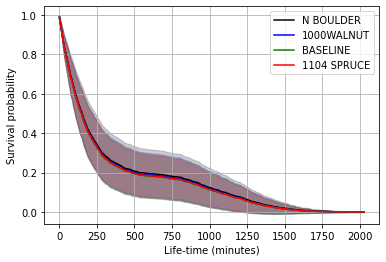

In [518]:
tods = ['Morning', 'Midday', 'Afternoon', 'Evening']#, 'Night']

temp1 = X5_S_test[X5_S_test['Station_Name'] == 'BOULDER / N BOULDER REC 1']
temp2 = X5_S_test[X5_S_test['Station_Name'] == 'COMM VITALITY / 1000WALNUT']
temp3 = X5_S_test[X5_S_test['Station_Name'] == 'BOULDER / BASELINE ST1']
temp4 = X5_S_test[X5_S_test['Station_Name'] == 'COMM VITALITY / 1104 SPRUCE1']

N=2

mean1 = []
upper1 = []
lower1 = []
mean2 = []
upper2 = []
lower2 = []
mean3 = []
upper3 = []
lower3 = []
mean4 = []
upper4 = []
lower4 = []

surv1 = survS[temp1.index]
surv2 = survS[temp2.index]
surv3 = survS[temp3.index]
surv4 = survS[temp4.index]

for k in range(len(timeS)):
    ## REC 1
    vals1 = surv1[:,k]
    mean1.append(np.mean(vals1))
    std1 = np.std(vals1)
    upper1.append(np.mean(vals1)+std1*N)
    lower1.append(np.mean(vals1)-std1*N)
    ## 1000WALNUT
    vals2 = surv2[:,k]
    mean2.append(np.mean(vals2))
    std2 = np.std(vals2)
    upper2.append(np.mean(vals2)+std2*N)
    lower2.append(np.mean(vals2)-std2*N)
    ## BASELINE ST1
    vals3 = surv3[:,k]
    mean3.append(np.mean(vals3))
    std3 = np.std(vals3)
    upper3.append(np.mean(vals3)+std3*N)
    lower3.append(np.mean(vals3)-std3*N)
    ## 1104 SPRUCE1
    vals4 = surv4[:,k]
    mean4.append(np.mean(vals4))
    std4 = np.std(vals4)
    upper4.append(np.mean(vals4)+std4*N)
    lower4.append(np.mean(vals4)-std4*N)
    
# plot
plt.fill_between(x=timeS,y1=lower1,y2=upper1, alpha=0.2, color='k')
plt.plot(timeS,mean1, label='N BOULDER', color='k')

plt.fill_between(x=timeS,y1=lower2,y2=upper2, alpha=0.2, color='b')
plt.plot(timeS,mean2, label='1000WALNUT', color='b')

plt.fill_between(x=timeS,y1=lower3,y2=upper3, alpha=0.2, color='g')
plt.plot(timeS,mean3, label='BASELINE', color='g')

plt.fill_between(x=timeS,y1=lower4,y2=upper4, alpha=0.2, color='r')
plt.plot(timeS,mean4, label='1104 SPRUCE', color='r')
plt.legend()

#plt.title("Short (<4H)")
plt.grid()
plt.xlabel("Life-time (minutes)")
plt.ylabel("Survival probability")
# plt.tight_layout()
plt.savefig('../visualization/SA_TOD_SHORT_twoStep.pdf',bbox_inches='tight')
plt.show()

#### Get table values

In [520]:
hour_steps = [0.5*60,1*60,2*60,4*60,8*60]
hour_steps_idx = []
for hour in hour_steps:
    #print(hour)
    temp = []
    for i in range(len(timeS)):
        if (timeS[i] >= hour) and (timeS[i] < hour+2):
            #print("{}H".format(hour/60))
            #print(i,time[i])
            temp.append(i)
    if len(temp) > 1:
        hour_steps_idx.append(int(np.float_(temp[0])))
    else:
        hour_steps_idx.append(temp)
hour_steps_idx

[30, 60, 120, 236, [408]]

In [532]:
hour_steps_idx = [30, 60, 120, 236, 408]

for stat in station_subset:
    temp = X5_S_test[X5_S_test['Station_Name'] == stat]
    temp_surv = survS[temp.index]
    print(stat)
    for i in range(len(hour_steps)):
        h_surv = temp_surv[:,hour_steps_idx[i]]
        m = round(np.mean(h_surv),2)
        std = round(np.std(h_surv),2)*2
        print("{} ({}): mean: {}  std: {}".format(hour_steps[i]/60,hour_steps[i],m,std))
print("\n")

BOULDER / N BOULDER REC 1
0.5 (30.0): mean: 0.85  std: 0.06
1.0 (60): mean: 0.74  std: 0.08
2.0 (120): mean: 0.57  std: 0.12
4.0 (240): mean: 0.36  std: 0.14
8.0 (480): mean: 0.21  std: 0.12
COMM VITALITY / 1000WALNUT
0.5 (30.0): mean: 0.85  std: 0.06
1.0 (60): mean: 0.74  std: 0.08
2.0 (120): mean: 0.56  std: 0.12
4.0 (240): mean: 0.35  std: 0.14
8.0 (480): mean: 0.2  std: 0.12
COMM VITALITY / 1104 SPRUCE1
0.5 (30.0): mean: 0.85  std: 0.04
1.0 (60): mean: 0.74  std: 0.08
2.0 (120): mean: 0.56  std: 0.12
4.0 (240): mean: 0.34  std: 0.12
8.0 (480): mean: 0.2  std: 0.1
BOULDER / BASELINE ST1
0.5 (30.0): mean: 0.84  std: 0.06
1.0 (60): mean: 0.74  std: 0.08
2.0 (120): mean: 0.56  std: 0.12
4.0 (240): mean: 0.34  std: 0.14
8.0 (480): mean: 0.2  std: 0.12




#### LONG

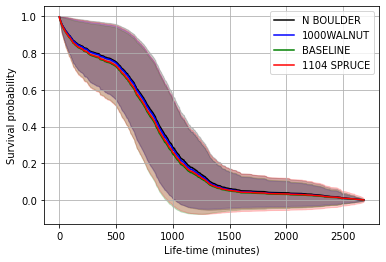

In [517]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
tods = ['Morning', 'Midday', 'Afternoon', 'Evening']#, 'Night']

temp1 = X5_L_test[X5_L_test['Station_Name'] == 'BOULDER / N BOULDER REC 1']
temp2 = X5_L_test[X5_L_test['Station_Name'] == 'COMM VITALITY / 1000WALNUT']
temp3 = X5_L_test[X5_L_test['Station_Name'] == 'BOULDER / BASELINE ST1']
temp4 = X5_L_test[X5_L_test['Station_Name'] == 'COMM VITALITY / 1104 SPRUCE1']

N = 2

mean1 = []
upper1 = []
lower1 = []
mean2 = []
upper2 = []
lower2 = []
mean3 = []
upper3 = []
lower3 = []
mean4 = []
upper4 = []
lower4 = []

surv1 = survL[temp1.index]
surv2 = survL[temp2.index]
surv3 = survL[temp3.index]
surv4 = survL[temp4.index]

for k in range(len(timeL)):
    ## REC 1
    vals1 = surv1[:,k]
    mean1.append(np.mean(vals1))
    std1 = np.std(vals1)
    upper1.append(np.mean(vals1)+std1*N)
    lower1.append(np.mean(vals1)-std1*N)
    ## 1000WALNUT
    vals2 = surv2[:,k]
    mean2.append(np.mean(vals2))
    std2 = np.std(vals2)
    upper2.append(np.mean(vals2)+std2*N)
    lower2.append(np.mean(vals2)-std2*N)
    ## BASELINE ST1
    vals3 = surv3[:,k]
    mean3.append(np.mean(vals3))
    std3 = np.std(vals3)
    upper3.append(np.mean(vals3)+std3*N)
    lower3.append(np.mean(vals3)-std3*N)
    ## 1104 SPRUCE1
    vals4 = surv4[:,k]
    mean4.append(np.mean(vals4))
    std4 = np.std(vals4)
    upper4.append(np.mean(vals4)+std4*N)
    lower4.append(np.mean(vals4)-std4*N)
    
# plot
plt.fill_between(x=timeL,y1=lower1,y2=upper1, alpha=0.2, color='k')
plt.plot(timeL,mean1, label='N BOULDER', color='k')

plt.fill_between(x=timeL,y1=lower2,y2=upper2, alpha=0.2, color='b')
plt.plot(timeL,mean2, label='1000WALNUT', color='b')

plt.fill_between(x=timeL,y1=lower3,y2=upper3, alpha=0.2, color='g')
plt.plot(timeL,mean3, label='BASELINE', color='g')

plt.fill_between(x=timeL,y1=lower4,y2=upper4, alpha=0.2, color='r')
plt.plot(timeL,mean4, label='1104 SPRUCE', color='r')
plt.legend()

#plt.title("Long (>=4H)")
plt.grid()
plt.xlabel("Life-time (minutes)")
plt.ylabel("Survival probability")
# plt.tight_layout()
plt.savefig('../visualization/SA_TOD_LONG_twoStep.pdf',bbox_inches='tight')
plt.show()

#### Get table values

In [526]:
hour_steps = [0.5*60,1*60,2*60,4*60,8*60]
hour_steps_idx = []
for hour in hour_steps:
    #print(hour)
    temp = []
    for i in range(len(timeL)):
        if (timeL[i] >= hour) and (timeL[i] < hour+3):
            #print("{}H".format(hour/60))
            #print(i,time[i])
            temp.append(i)
    if len(temp) > 1:
        hour_steps_idx.append(int(np.float_(temp[0])))
    else:
        hour_steps_idx.append(temp)
hour_steps_idx

[27, 53, [99], 155, [246]]

In [529]:
hour_steps_idx = [27, 53, 99, 155, 246]

for stat in station_subset:
    temp = X5_L_test[X5_L_test['Station_Name'] == stat]
    temp_surv = survL[temp.index]
    print(stat)
    for i in range(len(hour_steps)):
        h_surv = temp_surv[:,hour_steps_idx[i]]
        m = round(np.mean(h_surv),2)
        std = round(np.std(h_surv),2)*2
        print("{} ({}): mean: {}  std: {}".format(hour_steps[i]/60,hour_steps[i],m,std))
print("\n")

BOULDER / N BOULDER REC 1
0.5 (30.0): mean: 0.95  std: 0.06
1.0 (60): mean: 0.92  std: 0.08
2.0 (120): mean: 0.87  std: 0.12
4.0 (240): mean: 0.82  std: 0.16
8.0 (480): mean: 0.76  std: 0.2
COMM VITALITY / 1000WALNUT
0.5 (30.0): mean: 0.95  std: 0.06
1.0 (60): mean: 0.91  std: 0.08
2.0 (120): mean: 0.86  std: 0.12
4.0 (240): mean: 0.82  std: 0.16
8.0 (480): mean: 0.75  std: 0.2
COMM VITALITY / 1104 SPRUCE1
0.5 (30.0): mean: 0.94  std: 0.06
1.0 (60): mean: 0.91  std: 0.08
2.0 (120): mean: 0.86  std: 0.14
4.0 (240): mean: 0.81  std: 0.16
8.0 (480): mean: 0.74  std: 0.22
BOULDER / BASELINE ST1
0.5 (30.0): mean: 0.94  std: 0.06
1.0 (60): mean: 0.91  std: 0.08
2.0 (120): mean: 0.85  std: 0.12
4.0 (240): mean: 0.81  std: 0.16
8.0 (480): mean: 0.73  std: 0.2


